In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pdb
from tqdm import tqdm
from collections import OrderedDict
import copy

import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, './src')
from data import Dataset
from models import HMC_vanilla

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['dataset_name'] = 'boston_housing'
if args['dataset_name'].find('mnist') > -1:
    args['num_epoches'] = 201
    args['print_info'] = 50
    args['n_IS'] = 10000
    
    args['train_batch_size'] = 100
    args['val_dataset'] = 10000
    args['val_batch_size'] = 100
    args['test_batch_size'] = 100
else:
    args['n_IS'] = 1000
    args['num_epoches'] = 10001
    args['print_info'] = 1000
    args['train_batch_size'] = 100
    args['val_dataset'] = 100
    args['val_batch_size'] = 20
    args['test_batch_size'] = 10

In [5]:
dataset = Dataset(args)
args.in_features = dataset.in_features[0]
dataset.in_features[0]

/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


Train data shape 406


13

In [6]:
X_train = torch.tensor(dataset.x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(dataset.y_train, device=device, dtype=torch.float32)

X_val = torch.tensor(dataset.x_val, device=device, dtype=torch.float32)
y_val = torch.tensor(dataset.y_val, device=device, dtype=torch.float32)

In [7]:
def load_parameters(model, param_vector, params_shapes):
    left_boader = 0
    tensors = []
    for shape in params_shapes:
        cur_len = np.prod(shape)
        tensors.append(param_vector[left_boader: left_boader+cur_len].view(*shape))
        left_boader += cur_len
    d = OrderedDict()
    model_clone = copy.deepcopy(model)
    for i, name in enumerate(model_clone.named_parameters()):
        d[name[0]] = tensors[i]
    model_clone.load_state_dict(d)
    model_clone.to(model.device)
    return model_clone

$p(w|x) = \frac{p(w, x)}{\int p(x, w)dw} \sim p(x|w)p(w)$

In [8]:
class Simple_model(nn.Module):
    def __init__(self, args):
        super(Simple_model, self).__init__()
        in_features = args.in_features
        self.device = args.device
        self.l1 = nn.Linear(in_features, 3*in_features)
        self.l2 = nn.Linear(3*in_features, 1)
        self.activation = nn.Softplus()
        self.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=self.device),
                                                     scale=torch.tensor(1., dtype=torch.float32, device=self.device))
        
    def forward(self, x):
        h = self.activation(self.l1(x))
        h = self.l2(h)
        return h
    
    def log_prob(self, x, z):
        '''
        x - data vector
        z - vector of all parameters
        '''
#         pdb.set_trace()
        log_prior = self.std_normal.log_prob(z[0]).sum()
        loaded_model = load_parameters(self, z[0], params_shapes)
        y_pred = loaded_model(x)
        log_likelihood = torch.distributions.Normal(loc=y_train,
                                                     scale=torch.tensor(1., dtype=torch.float32, device=self.device)).log_prob(y_pred).sum()
#         print('log_likelihood', log_likelihood)
        logdensity = log_likelihood + log_prior
        return logdensity[None]

In [9]:
model = Simple_model(args)

In [10]:
params_shapes = [p.shape for p in list(model.parameters())]
print(params_shapes)
overall_params = sum([np.prod(el) for el in params_shapes])
print(f'Overall number of parameters is {overall_params}')

[torch.Size([39, 13]), torch.Size([39]), torch.Size([1, 39]), torch.Size([1])]
Overall number of parameters is 586


In [11]:
initial_parameters = torch.randn((overall_params, 1), dtype=torch.float32, device=device)

In [12]:
L = 100000 # num of hmc transitions
args.N = 3
args.alpha = 0.5
args.gamma = 0.001
args.use_partialref = False
args.use_barker = False


hmc_transition = HMC_vanilla(args)

In [13]:
q_new = initial_parameters
a_list = []

model_new = copy.deepcopy(load_parameters(model, q_new, params_shapes))

for l in tqdm(range(L)):
    q_new, _, a = hmc_transition.make_transition(q_old=q_new[None], p_old=None, target_distr=model_new, x=X_train)
    a_list.append(a.cpu().numpy())
    model_new = copy.deepcopy(load_parameters(model_new, q_new[0], params_shapes))
    q_new = q_new[0]
    if l % 500 == 0:
        print(f'Mean acceptance rate {np.mean(a_list)}')
        a_list = []
        y_pred = model_new(X_train)
        print(f"At L={l} MSE on train is {((y_pred.squeeze() - y_train.squeeze())**2).mean()}")
        
        y_pred = model_new(X_val)
        print(f"At L={l} MSE on validation is {((y_pred.squeeze() - y_val.squeeze())**2).mean()}")

  0%|          | 1/100000 [00:00<4:35:42,  6.04it/s]

Mean acceptance rate 0.0
At L=0 MSE on train is 297507.6875
At L=0 MSE on validation is 357886.3125


  1%|          | 524/100000 [00:04<13:42, 120.88it/s]

Mean acceptance rate 0.4320000112056732
At L=500 MSE on train is 70784.046875
At L=500 MSE on validation is 80793.359375


  1%|          | 1018/100000 [00:08<13:42, 120.35it/s]

Mean acceptance rate 0.39800000190734863
At L=1000 MSE on train is 27483.634765625
At L=1000 MSE on validation is 33596.07421875


  2%|▏         | 1525/100000 [00:12<13:40, 119.96it/s]

Mean acceptance rate 0.2980000078678131
At L=1500 MSE on train is 8403.353515625
At L=1500 MSE on validation is 10703.53515625


  2%|▏         | 2019/100000 [00:16<13:35, 120.08it/s]

Mean acceptance rate 0.20000000298023224
At L=2000 MSE on train is 3949.705078125
At L=2000 MSE on validation is 4781.80224609375


  3%|▎         | 2515/100000 [00:21<13:38, 119.08it/s]

Mean acceptance rate 0.18400000035762787
At L=2500 MSE on train is 2247.709716796875
At L=2500 MSE on validation is 2274.044921875


  3%|▎         | 3019/100000 [00:25<13:39, 118.29it/s]

Mean acceptance rate 0.09200000017881393
At L=3000 MSE on train is 1700.632080078125
At L=3000 MSE on validation is 1659.560791015625


  4%|▎         | 3522/100000 [00:29<13:20, 120.57it/s]

Mean acceptance rate 0.07800000160932541
At L=3500 MSE on train is 1323.77734375
At L=3500 MSE on validation is 1357.2139892578125


  4%|▍         | 4016/100000 [00:33<13:21, 119.80it/s]

Mean acceptance rate 0.06599999964237213
At L=4000 MSE on train is 1093.98779296875
At L=4000 MSE on validation is 1237.5574951171875


  5%|▍         | 4523/100000 [00:37<13:12, 120.44it/s]

Mean acceptance rate 0.04600000008940697
At L=4500 MSE on train is 951.540771484375
At L=4500 MSE on validation is 1078.245361328125


  5%|▌         | 5017/100000 [00:41<13:08, 120.50it/s]

Mean acceptance rate 0.04399999976158142
At L=5000 MSE on train is 832.2051391601562
At L=5000 MSE on validation is 925.6879272460938


  6%|▌         | 5524/100000 [00:46<13:02, 120.67it/s]

Mean acceptance rate 0.03200000151991844
At L=5500 MSE on train is 781.697021484375
At L=5500 MSE on validation is 850.8895263671875


  6%|▌         | 6018/100000 [00:50<12:57, 120.88it/s]

Mean acceptance rate 0.041999999433755875
At L=6000 MSE on train is 704.6909790039062
At L=6000 MSE on validation is 765.8909301757812


  7%|▋         | 6512/100000 [00:54<12:56, 120.44it/s]

Mean acceptance rate 0.05000000074505806
At L=6500 MSE on train is 613.1900024414062
At L=6500 MSE on validation is 688.6083374023438


  7%|▋         | 7020/100000 [00:58<12:58, 119.51it/s]

Mean acceptance rate 0.035999998450279236
At L=7000 MSE on train is 572.4664306640625
At L=7000 MSE on validation is 642.711669921875


  8%|▊         | 7518/100000 [01:02<12:54, 119.48it/s]

Mean acceptance rate 0.026000000536441803
At L=7500 MSE on train is 529.2977294921875
At L=7500 MSE on validation is 576.24951171875


  8%|▊         | 8014/100000 [01:06<12:59, 118.05it/s]

Mean acceptance rate 0.019999999552965164
At L=8000 MSE on train is 498.5419006347656
At L=8000 MSE on validation is 528.5553588867188


  9%|▊         | 8518/100000 [01:11<12:54, 118.13it/s]

Mean acceptance rate 0.026000000536441803
At L=8500 MSE on train is 463.6416320800781
At L=8500 MSE on validation is 482.1882629394531


  9%|▉         | 9022/100000 [01:15<12:49, 118.28it/s]

Mean acceptance rate 0.009999999776482582
At L=9000 MSE on train is 454.2706298828125
At L=9000 MSE on validation is 459.2155456542969


 10%|▉         | 9514/100000 [01:19<12:46, 118.07it/s]

Mean acceptance rate 0.024000000208616257
At L=9500 MSE on train is 431.8564147949219
At L=9500 MSE on validation is 436.4761962890625


 10%|█         | 10019/100000 [01:23<12:33, 119.48it/s]

Mean acceptance rate 0.01600000075995922
At L=10000 MSE on train is 420.734375
At L=10000 MSE on validation is 406.4636535644531


 11%|█         | 10523/100000 [01:28<12:42, 117.35it/s]

Mean acceptance rate 0.019999999552965164
At L=10500 MSE on train is 403.3349609375
At L=10500 MSE on validation is 402.3445129394531


 11%|█         | 11015/100000 [01:32<12:37, 117.41it/s]

Mean acceptance rate 0.014000000432133675
At L=11000 MSE on train is 385.6182861328125
At L=11000 MSE on validation is 371.3907775878906


 12%|█▏        | 11519/100000 [01:36<12:30, 117.82it/s]

Mean acceptance rate 0.02199999988079071
At L=11500 MSE on train is 366.62310791015625
At L=11500 MSE on validation is 331.3218994140625


 12%|█▏        | 12023/100000 [01:40<12:24, 118.21it/s]

Mean acceptance rate 0.03400000184774399
At L=12000 MSE on train is 341.62738037109375
At L=12000 MSE on validation is 295.33160400390625


 13%|█▎        | 12515/100000 [01:44<12:24, 117.57it/s]

Mean acceptance rate 0.017999999225139618
At L=12500 MSE on train is 328.57818603515625
At L=12500 MSE on validation is 295.4582214355469


 13%|█▎        | 13023/100000 [01:49<12:00, 120.75it/s]

Mean acceptance rate 0.00800000037997961
At L=13000 MSE on train is 317.8843994140625
At L=13000 MSE on validation is 280.1178894042969


 14%|█▎        | 13523/100000 [01:53<12:10, 118.44it/s]

Mean acceptance rate 0.01600000075995922
At L=13500 MSE on train is 304.6078796386719
At L=13500 MSE on validation is 280.04779052734375


 14%|█▍        | 14015/100000 [01:57<11:55, 120.15it/s]

Mean acceptance rate 0.014000000432133675
At L=14000 MSE on train is 293.6384582519531
At L=14000 MSE on validation is 276.86865234375


 15%|█▍        | 14522/100000 [02:01<11:50, 120.38it/s]

Mean acceptance rate 0.012000000104308128
At L=14500 MSE on train is 282.21124267578125
At L=14500 MSE on validation is 264.63201904296875


 15%|█▌        | 15016/100000 [02:05<11:42, 121.03it/s]

Mean acceptance rate 0.014000000432133675
At L=15000 MSE on train is 270.35479736328125
At L=15000 MSE on validation is 248.0952606201172


 16%|█▌        | 15523/100000 [02:09<11:40, 120.67it/s]

Mean acceptance rate 0.012000000104308128
At L=15500 MSE on train is 264.7862243652344
At L=15500 MSE on validation is 229.31378173828125


 16%|█▌        | 16018/100000 [02:14<11:43, 119.33it/s]

Mean acceptance rate 0.009999999776482582
At L=16000 MSE on train is 259.25262451171875
At L=16000 MSE on validation is 224.6814422607422


 17%|█▋        | 16522/100000 [02:18<11:40, 119.18it/s]

Mean acceptance rate 0.017999999225139618
At L=16500 MSE on train is 243.478271484375
At L=16500 MSE on validation is 204.9186248779297


 17%|█▋        | 17022/100000 [02:22<11:28, 120.57it/s]

Mean acceptance rate 0.00800000037997961
At L=17000 MSE on train is 231.12646484375
At L=17000 MSE on validation is 195.62335205078125


 18%|█▊        | 17520/100000 [02:26<11:30, 119.48it/s]

Mean acceptance rate 0.006000000052154064
At L=17500 MSE on train is 225.60186767578125
At L=17500 MSE on validation is 193.135498046875


 18%|█▊        | 18016/100000 [02:30<11:20, 120.39it/s]

Mean acceptance rate 0.012000000104308128
At L=18000 MSE on train is 216.60491943359375
At L=18000 MSE on validation is 178.51510620117188


 19%|█▊        | 18515/100000 [02:34<11:29, 118.14it/s]

Mean acceptance rate 0.00800000037997961
At L=18500 MSE on train is 214.12765502929688
At L=18500 MSE on validation is 172.74374389648438


 19%|█▉        | 19020/100000 [02:39<11:19, 119.14it/s]

Mean acceptance rate 0.02199999988079071
At L=19000 MSE on train is 199.09347534179688
At L=19000 MSE on validation is 159.9449005126953


 20%|█▉        | 19524/100000 [02:43<11:10, 120.03it/s]

Mean acceptance rate 0.004000000189989805
At L=19500 MSE on train is 198.12420654296875
At L=19500 MSE on validation is 159.22853088378906


 20%|██        | 20018/100000 [02:47<11:03, 120.63it/s]

Mean acceptance rate 0.012000000104308128
At L=20000 MSE on train is 192.6903076171875
At L=20000 MSE on validation is 155.4031982421875


 21%|██        | 20525/100000 [02:51<10:57, 120.82it/s]

Mean acceptance rate 0.0
At L=20500 MSE on train is 192.6903076171875
At L=20500 MSE on validation is 155.4031982421875


 21%|██        | 21017/100000 [02:55<11:00, 119.50it/s]

Mean acceptance rate 0.0020000000949949026
At L=21000 MSE on train is 192.1071014404297
At L=21000 MSE on validation is 153.38119506835938


 22%|██▏       | 21516/100000 [02:59<10:57, 119.28it/s]

Mean acceptance rate 0.006000000052154064
At L=21500 MSE on train is 188.325927734375
At L=21500 MSE on validation is 148.2439727783203


 22%|██▏       | 22023/100000 [03:04<10:54, 119.11it/s]

Mean acceptance rate 0.004000000189989805
At L=22000 MSE on train is 187.5845947265625
At L=22000 MSE on validation is 147.7509307861328


 23%|██▎       | 22521/100000 [03:08<10:47, 119.58it/s]

Mean acceptance rate 0.004000000189989805
At L=22500 MSE on train is 186.949951171875
At L=22500 MSE on validation is 148.62083435058594


 23%|██▎       | 23021/100000 [03:12<10:44, 119.41it/s]

Mean acceptance rate 0.012000000104308128
At L=23000 MSE on train is 179.3839569091797
At L=23000 MSE on validation is 139.0155487060547


 24%|██▎       | 23518/100000 [03:16<10:40, 119.45it/s]

Mean acceptance rate 0.00800000037997961
At L=23500 MSE on train is 175.66062927246094
At L=23500 MSE on validation is 132.21127319335938


 24%|██▍       | 24018/100000 [03:20<10:36, 119.31it/s]

Mean acceptance rate 0.01600000075995922
At L=24000 MSE on train is 165.43846130371094
At L=24000 MSE on validation is 123.14440155029297


 25%|██▍       | 24519/100000 [03:25<10:32, 119.43it/s]

Mean acceptance rate 0.0020000000949949026
At L=24500 MSE on train is 164.8087615966797
At L=24500 MSE on validation is 122.75186920166016


 25%|██▌       | 25013/100000 [03:29<10:28, 119.28it/s]

Mean acceptance rate 0.0020000000949949026
At L=25000 MSE on train is 164.125
At L=25000 MSE on validation is 123.10667419433594


 26%|██▌       | 25513/100000 [03:33<10:24, 119.26it/s]

Mean acceptance rate 0.0020000000949949026
At L=25500 MSE on train is 163.6612548828125
At L=25500 MSE on validation is 122.7404556274414


 26%|██▌       | 26021/100000 [03:37<10:19, 119.40it/s]

Mean acceptance rate 0.006000000052154064
At L=26000 MSE on train is 159.78228759765625
At L=26000 MSE on validation is 118.3298568725586


 27%|██▋       | 26521/100000 [03:41<10:23, 117.92it/s]

Mean acceptance rate 0.004000000189989805
At L=26500 MSE on train is 159.24365234375
At L=26500 MSE on validation is 117.1433334350586


 27%|██▋       | 27013/100000 [03:45<10:18, 117.93it/s]

Mean acceptance rate 0.004000000189989805
At L=27000 MSE on train is 159.03492736816406
At L=27000 MSE on validation is 119.24971771240234


 28%|██▊       | 27517/100000 [03:50<10:16, 117.51it/s]

Mean acceptance rate 0.00800000037997961
At L=27500 MSE on train is 154.55130004882812
At L=27500 MSE on validation is 118.76988983154297


 28%|██▊       | 28013/100000 [03:54<10:03, 119.34it/s]

Mean acceptance rate 0.006000000052154064
At L=28000 MSE on train is 151.73963928222656
At L=28000 MSE on validation is 116.6910629272461


 29%|██▊       | 28518/100000 [03:58<10:08, 117.56it/s]

Mean acceptance rate 0.004000000189989805
At L=28500 MSE on train is 150.4662322998047
At L=28500 MSE on validation is 110.83922576904297


 29%|██▉       | 29023/100000 [04:02<09:56, 118.97it/s]

Mean acceptance rate 0.0020000000949949026
At L=29000 MSE on train is 149.74476623535156
At L=29000 MSE on validation is 109.21808624267578


 30%|██▉       | 29525/100000 [04:07<09:45, 120.37it/s]

Mean acceptance rate 0.0020000000949949026
At L=29500 MSE on train is 149.52870178222656
At L=29500 MSE on validation is 110.30546569824219


 30%|███       | 30019/100000 [04:11<09:39, 120.75it/s]

Mean acceptance rate 0.0020000000949949026
At L=30000 MSE on train is 148.6159210205078
At L=30000 MSE on validation is 109.76522064208984


 31%|███       | 30513/100000 [04:15<09:34, 121.01it/s]

Mean acceptance rate 0.0020000000949949026
At L=30500 MSE on train is 148.37258911132812
At L=30500 MSE on validation is 108.97248840332031


 31%|███       | 31020/100000 [04:19<09:19, 123.22it/s]

Mean acceptance rate 0.006000000052154064
At L=31000 MSE on train is 147.17068481445312
At L=31000 MSE on validation is 110.72581481933594


 32%|███▏      | 31514/100000 [04:23<09:16, 123.09it/s]

Mean acceptance rate 0.0
At L=31500 MSE on train is 147.17068481445312
At L=31500 MSE on validation is 110.72581481933594


 32%|███▏      | 32021/100000 [04:27<09:16, 122.05it/s]

Mean acceptance rate 0.004000000189989805
At L=32000 MSE on train is 145.9093780517578
At L=32000 MSE on validation is 109.14701080322266


 33%|███▎      | 32515/100000 [04:31<09:17, 120.96it/s]

Mean acceptance rate 0.00800000037997961
At L=32500 MSE on train is 143.63856506347656
At L=32500 MSE on validation is 105.12030029296875


 33%|███▎      | 33013/100000 [04:35<09:23, 118.89it/s]

Mean acceptance rate 0.00800000037997961
At L=33000 MSE on train is 139.0858917236328
At L=33000 MSE on validation is 104.39173889160156


 34%|███▎      | 33517/100000 [04:39<09:12, 120.32it/s]

Mean acceptance rate 0.006000000052154064
At L=33500 MSE on train is 137.73410034179688
At L=33500 MSE on validation is 105.43476104736328


 34%|███▍      | 34023/100000 [04:44<09:14, 118.94it/s]

Mean acceptance rate 0.006000000052154064
At L=34000 MSE on train is 134.2213592529297
At L=34000 MSE on validation is 100.82935333251953


 35%|███▍      | 34515/100000 [04:48<09:11, 118.83it/s]

Mean acceptance rate 0.009999999776482582
At L=34500 MSE on train is 130.0213623046875
At L=34500 MSE on validation is 95.54347229003906


 35%|███▌      | 35019/100000 [04:52<09:10, 118.11it/s]

Mean acceptance rate 0.004000000189989805
At L=35000 MSE on train is 129.11680603027344
At L=35000 MSE on validation is 99.11048889160156


 36%|███▌      | 35514/100000 [04:56<08:59, 119.42it/s]

Mean acceptance rate 0.006000000052154064
At L=35500 MSE on train is 127.62413024902344
At L=35500 MSE on validation is 94.91435241699219


 36%|███▌      | 36013/100000 [05:00<08:55, 119.44it/s]

Mean acceptance rate 0.0020000000949949026
At L=36000 MSE on train is 127.46063995361328
At L=36000 MSE on validation is 96.08773040771484


 37%|███▋      | 36524/100000 [05:05<08:44, 120.91it/s]

Mean acceptance rate 0.012000000104308128
At L=36500 MSE on train is 123.10443115234375
At L=36500 MSE on validation is 92.97220611572266


 37%|███▋      | 37018/100000 [05:09<08:36, 121.89it/s]

Mean acceptance rate 0.0020000000949949026
At L=37000 MSE on train is 122.91325378417969
At L=37000 MSE on validation is 92.63126373291016


 38%|███▊      | 37525/100000 [05:13<08:32, 121.97it/s]

Mean acceptance rate 0.004000000189989805
At L=37500 MSE on train is 122.85311889648438
At L=37500 MSE on validation is 94.21853637695312


 38%|███▊      | 38020/100000 [05:17<08:30, 121.43it/s]

Mean acceptance rate 0.00800000037997961
At L=38000 MSE on train is 120.74775695800781
At L=38000 MSE on validation is 93.7979736328125


 39%|███▊      | 38514/100000 [05:21<08:25, 121.60it/s]

Mean acceptance rate 0.0020000000949949026
At L=38500 MSE on train is 120.48262023925781
At L=38500 MSE on validation is 95.5589370727539


 39%|███▉      | 39021/100000 [05:25<08:20, 121.81it/s]

Mean acceptance rate 0.0020000000949949026
At L=39000 MSE on train is 120.4662857055664
At L=39000 MSE on validation is 96.75435638427734


 40%|███▉      | 39515/100000 [05:29<08:16, 121.78it/s]

Mean acceptance rate 0.0
At L=39500 MSE on train is 120.4662857055664
At L=39500 MSE on validation is 96.75435638427734


 40%|████      | 40022/100000 [05:33<08:12, 121.68it/s]

Mean acceptance rate 0.004000000189989805
At L=40000 MSE on train is 119.45832824707031
At L=40000 MSE on validation is 94.13265228271484


 41%|████      | 40516/100000 [05:37<08:09, 121.55it/s]

Mean acceptance rate 0.0020000000949949026
At L=40500 MSE on train is 119.17179870605469
At L=40500 MSE on validation is 91.44114685058594


 41%|████      | 41023/100000 [05:42<08:05, 121.58it/s]

Mean acceptance rate 0.0
At L=41000 MSE on train is 119.17179870605469
At L=41000 MSE on validation is 91.44114685058594


 42%|████▏     | 41517/100000 [05:46<08:02, 121.29it/s]

Mean acceptance rate 0.004000000189989805
At L=41500 MSE on train is 118.45305633544922
At L=41500 MSE on validation is 94.24683380126953


 42%|████▏     | 42020/100000 [05:50<08:10, 118.23it/s]

Mean acceptance rate 0.0020000000949949026
At L=42000 MSE on train is 117.05266571044922
At L=42000 MSE on validation is 89.97274017333984


 43%|████▎     | 42524/100000 [05:54<08:07, 117.87it/s]

Mean acceptance rate 0.0
At L=42500 MSE on train is 117.05266571044922
At L=42500 MSE on validation is 89.97274017333984


 43%|████▎     | 43017/100000 [05:58<07:58, 119.16it/s]

Mean acceptance rate 0.004000000189989805
At L=43000 MSE on train is 116.655029296875
At L=43000 MSE on validation is 90.49542999267578


 44%|████▎     | 43514/100000 [06:02<07:54, 119.13it/s]

Mean acceptance rate 0.0020000000949949026
At L=43500 MSE on train is 116.21742248535156
At L=43500 MSE on validation is 89.32213592529297


 44%|████▍     | 44019/100000 [06:07<07:46, 120.03it/s]

Mean acceptance rate 0.0
At L=44000 MSE on train is 116.21742248535156
At L=44000 MSE on validation is 89.32213592529297


 45%|████▍     | 44513/100000 [06:11<07:42, 119.96it/s]

Mean acceptance rate 0.0020000000949949026
At L=44500 MSE on train is 115.0799331665039
At L=44500 MSE on validation is 88.71644592285156


 45%|████▌     | 45020/100000 [06:15<07:35, 120.81it/s]

Mean acceptance rate 0.0020000000949949026
At L=45000 MSE on train is 114.54814147949219
At L=45000 MSE on validation is 86.74620056152344


 46%|████▌     | 45514/100000 [06:19<07:27, 121.74it/s]

Mean acceptance rate 0.006000000052154064
At L=45500 MSE on train is 111.4033203125
At L=45500 MSE on validation is 86.48268127441406


 46%|████▌     | 46021/100000 [06:23<07:27, 120.63it/s]

Mean acceptance rate 0.0
At L=46000 MSE on train is 111.4033203125
At L=46000 MSE on validation is 86.48268127441406


 47%|████▋     | 46515/100000 [06:27<07:24, 120.22it/s]

Mean acceptance rate 0.0
At L=46500 MSE on train is 111.4033203125
At L=46500 MSE on validation is 86.48268127441406


 47%|████▋     | 47022/100000 [06:31<07:21, 120.05it/s]

Mean acceptance rate 0.004000000189989805
At L=47000 MSE on train is 110.25970458984375
At L=47000 MSE on validation is 84.37348175048828


 48%|████▊     | 47516/100000 [06:36<07:17, 120.02it/s]

Mean acceptance rate 0.006000000052154064
At L=47500 MSE on train is 108.46239471435547
At L=47500 MSE on validation is 86.1192398071289


 48%|████▊     | 48023/100000 [06:40<07:11, 120.41it/s]

Mean acceptance rate 0.006000000052154064
At L=48000 MSE on train is 107.45160675048828
At L=48000 MSE on validation is 80.64021301269531


 49%|████▊     | 48517/100000 [06:44<07:05, 120.96it/s]

Mean acceptance rate 0.006000000052154064
At L=48500 MSE on train is 106.74583435058594
At L=48500 MSE on validation is 84.11151885986328


 49%|████▉     | 49018/100000 [06:48<07:06, 119.49it/s]

Mean acceptance rate 0.0
At L=49000 MSE on train is 106.74583435058594
At L=49000 MSE on validation is 84.11151885986328


 50%|████▉     | 49517/100000 [06:52<06:54, 121.72it/s]

Mean acceptance rate 0.0020000000949949026
At L=49500 MSE on train is 105.4183349609375
At L=49500 MSE on validation is 84.31175231933594


 50%|█████     | 50017/100000 [06:56<07:02, 118.25it/s]

Mean acceptance rate 0.0
At L=50000 MSE on train is 105.4183349609375
At L=50000 MSE on validation is 84.31175231933594


 51%|█████     | 50521/100000 [07:01<06:58, 118.30it/s]

Mean acceptance rate 0.0
At L=50500 MSE on train is 105.4183349609375
At L=50500 MSE on validation is 84.31175231933594


 51%|█████     | 51013/100000 [07:05<06:55, 117.79it/s]

Mean acceptance rate 0.0
At L=51000 MSE on train is 105.4183349609375
At L=51000 MSE on validation is 84.31175231933594


 52%|█████▏    | 51517/100000 [07:09<06:51, 117.78it/s]

Mean acceptance rate 0.0
At L=51500 MSE on train is 105.4183349609375
At L=51500 MSE on validation is 84.31175231933594


 52%|█████▏    | 52021/100000 [07:13<06:45, 118.18it/s]

Mean acceptance rate 0.0
At L=52000 MSE on train is 105.4183349609375
At L=52000 MSE on validation is 84.31175231933594


 53%|█████▎    | 52513/100000 [07:17<06:43, 117.80it/s]

Mean acceptance rate 0.0
At L=52500 MSE on train is 105.4183349609375
At L=52500 MSE on validation is 84.31175231933594


 53%|█████▎    | 53017/100000 [07:22<06:38, 117.96it/s]

Mean acceptance rate 0.0
At L=53000 MSE on train is 105.4183349609375
At L=53000 MSE on validation is 84.31175231933594


 54%|█████▎    | 53521/100000 [07:26<06:34, 117.83it/s]

Mean acceptance rate 0.0020000000949949026
At L=53500 MSE on train is 105.23306274414062
At L=53500 MSE on validation is 81.73665618896484


 54%|█████▍    | 54013/100000 [07:30<06:29, 117.93it/s]

Mean acceptance rate 0.0020000000949949026
At L=54000 MSE on train is 105.08820343017578
At L=54000 MSE on validation is 84.15988159179688


 55%|█████▍    | 54517/100000 [07:34<06:26, 117.59it/s]

Mean acceptance rate 0.004000000189989805
At L=54500 MSE on train is 103.54254150390625
At L=54500 MSE on validation is 79.35319519042969


 55%|█████▌    | 55024/100000 [07:39<06:16, 119.39it/s]

Mean acceptance rate 0.0
At L=55000 MSE on train is 103.54254150390625
At L=55000 MSE on validation is 79.35319519042969


 56%|█████▌    | 55518/100000 [07:43<06:16, 118.06it/s]

Mean acceptance rate 0.004000000189989805
At L=55500 MSE on train is 102.29754638671875
At L=55500 MSE on validation is 77.53408813476562


 56%|█████▌    | 56022/100000 [07:47<06:13, 117.71it/s]

Mean acceptance rate 0.0
At L=56000 MSE on train is 102.29754638671875
At L=56000 MSE on validation is 77.53408813476562


 57%|█████▋    | 56514/100000 [07:51<06:09, 117.76it/s]

Mean acceptance rate 0.0020000000949949026
At L=56500 MSE on train is 101.87313842773438
At L=56500 MSE on validation is 79.6076889038086


 57%|█████▋    | 57022/100000 [07:55<06:00, 119.27it/s]

Mean acceptance rate 0.0
At L=57000 MSE on train is 101.87313842773438
At L=57000 MSE on validation is 79.6076889038086


 58%|█████▊    | 57519/100000 [08:00<05:56, 119.22it/s]

Mean acceptance rate 0.004000000189989805
At L=57500 MSE on train is 101.51313018798828
At L=57500 MSE on validation is 80.31472778320312


 58%|█████▊    | 58014/100000 [08:04<05:48, 120.50it/s]

Mean acceptance rate 0.0020000000949949026
At L=58000 MSE on train is 101.15869140625
At L=58000 MSE on validation is 77.1180191040039


 59%|█████▊    | 58521/100000 [08:08<05:47, 119.30it/s]

Mean acceptance rate 0.0
At L=58500 MSE on train is 101.15869140625
At L=58500 MSE on validation is 77.1180191040039


 59%|█████▉    | 59013/100000 [08:12<05:49, 117.14it/s]

Mean acceptance rate 0.0
At L=59000 MSE on train is 101.15869140625
At L=59000 MSE on validation is 77.1180191040039


 60%|█████▉    | 59517/100000 [08:16<05:44, 117.52it/s]

Mean acceptance rate 0.004000000189989805
At L=59500 MSE on train is 100.22696685791016
At L=59500 MSE on validation is 76.7315673828125


 60%|██████    | 60016/100000 [08:21<05:33, 120.06it/s]

Mean acceptance rate 0.0020000000949949026
At L=60000 MSE on train is 100.12247467041016
At L=60000 MSE on validation is 76.36177825927734


 61%|██████    | 60523/100000 [08:25<05:26, 120.87it/s]

Mean acceptance rate 0.0
At L=60500 MSE on train is 100.12247467041016
At L=60500 MSE on validation is 76.36177825927734


 61%|██████    | 61019/100000 [08:29<05:26, 119.51it/s]

Mean acceptance rate 0.0020000000949949026
At L=61000 MSE on train is 99.95269775390625
At L=61000 MSE on validation is 77.22268676757812


 62%|██████▏   | 61518/100000 [08:33<05:21, 119.58it/s]

Mean acceptance rate 0.0020000000949949026
At L=61500 MSE on train is 99.4910888671875
At L=61500 MSE on validation is 76.55467224121094


 62%|██████▏   | 62016/100000 [08:37<05:17, 119.51it/s]

Mean acceptance rate 0.004000000189989805
At L=62000 MSE on train is 98.6604995727539
At L=62000 MSE on validation is 73.49301147460938


 63%|██████▎   | 62516/100000 [08:41<05:11, 120.33it/s]

Mean acceptance rate 0.0020000000949949026
At L=62500 MSE on train is 98.36578369140625
At L=62500 MSE on validation is 72.25666046142578


 63%|██████▎   | 63020/100000 [08:46<05:10, 119.08it/s]

Mean acceptance rate 0.0
At L=63000 MSE on train is 98.36578369140625
At L=63000 MSE on validation is 72.25666046142578


 64%|██████▎   | 63517/100000 [08:50<05:05, 119.38it/s]

Mean acceptance rate 0.0
At L=63500 MSE on train is 98.36578369140625
At L=63500 MSE on validation is 72.25666046142578


 64%|██████▍   | 64021/100000 [08:54<05:04, 118.08it/s]

Mean acceptance rate 0.0
At L=64000 MSE on train is 98.36578369140625
At L=64000 MSE on validation is 72.25666046142578


 65%|██████▍   | 64515/100000 [08:58<04:57, 119.26it/s]

Mean acceptance rate 0.0
At L=64500 MSE on train is 98.36578369140625
At L=64500 MSE on validation is 72.25666046142578


 65%|██████▌   | 65022/100000 [09:02<04:53, 119.18it/s]

Mean acceptance rate 0.004000000189989805
At L=65000 MSE on train is 98.20357513427734
At L=65000 MSE on validation is 73.91899108886719


 66%|██████▌   | 65519/100000 [09:07<04:49, 119.08it/s]

Mean acceptance rate 0.0020000000949949026
At L=65500 MSE on train is 97.14784240722656
At L=65500 MSE on validation is 70.77364349365234


 66%|██████▌   | 66023/100000 [09:11<04:44, 119.31it/s]

Mean acceptance rate 0.004000000189989805
At L=66000 MSE on train is 96.7393798828125
At L=66000 MSE on validation is 75.17655944824219


 67%|██████▋   | 66517/100000 [09:15<04:37, 120.82it/s]

Mean acceptance rate 0.0020000000949949026
At L=66500 MSE on train is 96.23213958740234
At L=66500 MSE on validation is 74.0357437133789


 67%|██████▋   | 67024/100000 [09:19<04:35, 119.86it/s]

Mean acceptance rate 0.0020000000949949026
At L=67000 MSE on train is 95.80884552001953
At L=67000 MSE on validation is 73.50975036621094


 68%|██████▊   | 67518/100000 [09:23<04:28, 120.84it/s]

Mean acceptance rate 0.00800000037997961
At L=67500 MSE on train is 94.6693344116211
At L=67500 MSE on validation is 71.27775573730469


 68%|██████▊   | 68014/100000 [09:27<04:29, 118.87it/s]

Mean acceptance rate 0.0
At L=68000 MSE on train is 94.6693344116211
At L=68000 MSE on validation is 71.27775573730469


 69%|██████▊   | 68518/100000 [09:32<04:24, 118.96it/s]

Mean acceptance rate 0.0
At L=68500 MSE on train is 94.6693344116211
At L=68500 MSE on validation is 71.27775573730469


 69%|██████▉   | 69022/100000 [09:36<04:22, 117.83it/s]

Mean acceptance rate 0.0
At L=69000 MSE on train is 94.6693344116211
At L=69000 MSE on validation is 71.27775573730469


 70%|██████▉   | 69516/100000 [09:40<04:16, 118.72it/s]

Mean acceptance rate 0.006000000052154064
At L=69500 MSE on train is 93.1288070678711
At L=69500 MSE on validation is 74.20243072509766


 70%|███████   | 70020/100000 [09:44<04:08, 120.66it/s]

Mean acceptance rate 0.00800000037997961
At L=70000 MSE on train is 91.68199157714844
At L=70000 MSE on validation is 72.5384292602539


 71%|███████   | 70513/100000 [09:48<04:10, 117.91it/s]

Mean acceptance rate 0.0
At L=70500 MSE on train is 91.68199157714844
At L=70500 MSE on validation is 72.5384292602539


 71%|███████   | 71017/100000 [09:53<04:06, 117.40it/s]

Mean acceptance rate 0.0
At L=71000 MSE on train is 91.68199157714844
At L=71000 MSE on validation is 72.5384292602539


 72%|███████▏  | 71523/100000 [09:57<03:58, 119.32it/s]

Mean acceptance rate 0.0
At L=71500 MSE on train is 91.68199157714844
At L=71500 MSE on validation is 72.5384292602539


 72%|███████▏  | 72014/100000 [10:01<03:54, 119.25it/s]

Mean acceptance rate 0.0
At L=72000 MSE on train is 91.68199157714844
At L=72000 MSE on validation is 72.5384292602539


 73%|███████▎  | 72524/100000 [10:05<03:53, 117.59it/s]

Mean acceptance rate 0.0
At L=72500 MSE on train is 91.68199157714844
At L=72500 MSE on validation is 72.5384292602539


 73%|███████▎  | 73016/100000 [10:09<03:51, 116.70it/s]

Mean acceptance rate 0.004000000189989805
At L=73000 MSE on train is 90.08055114746094
At L=73000 MSE on validation is 70.26203155517578


 74%|███████▎  | 73525/100000 [10:14<03:39, 120.86it/s]

Mean acceptance rate 0.0
At L=73500 MSE on train is 90.08055114746094
At L=73500 MSE on validation is 70.26203155517578


 74%|███████▍  | 74019/100000 [10:18<03:35, 120.60it/s]

Mean acceptance rate 0.0
At L=74000 MSE on train is 90.08055114746094
At L=74000 MSE on validation is 70.26203155517578


 75%|███████▍  | 74513/100000 [10:22<03:31, 120.69it/s]

Mean acceptance rate 0.0
At L=74500 MSE on train is 90.08055114746094
At L=74500 MSE on validation is 70.26203155517578


 75%|███████▌  | 75024/100000 [10:26<03:31, 118.07it/s]

Mean acceptance rate 0.004000000189989805
At L=75000 MSE on train is 89.5901107788086
At L=75000 MSE on validation is 73.4831314086914


 76%|███████▌  | 75516/100000 [10:30<03:28, 117.60it/s]

Mean acceptance rate 0.0
At L=75500 MSE on train is 89.5901107788086
At L=75500 MSE on validation is 73.4831314086914


 76%|███████▌  | 76020/100000 [10:35<03:23, 117.68it/s]

Mean acceptance rate 0.0
At L=76000 MSE on train is 89.5901107788086
At L=76000 MSE on validation is 73.4831314086914


 77%|███████▋  | 76519/100000 [10:39<03:14, 120.83it/s]

Mean acceptance rate 0.0
At L=76500 MSE on train is 89.5901107788086
At L=76500 MSE on validation is 73.4831314086914


 77%|███████▋  | 77024/100000 [10:43<03:12, 119.37it/s]

Mean acceptance rate 0.0
At L=77000 MSE on train is 89.5901107788086
At L=77000 MSE on validation is 73.4831314086914


 78%|███████▊  | 77518/100000 [10:47<03:11, 117.61it/s]

Mean acceptance rate 0.0
At L=77500 MSE on train is 89.5901107788086
At L=77500 MSE on validation is 73.4831314086914


 78%|███████▊  | 78015/100000 [10:51<03:05, 118.34it/s]

Mean acceptance rate 0.004000000189989805
At L=78000 MSE on train is 89.16365814208984
At L=78000 MSE on validation is 70.70960998535156


 79%|███████▊  | 78519/100000 [10:56<03:02, 117.53it/s]

Mean acceptance rate 0.0
At L=78500 MSE on train is 89.16365814208984
At L=78500 MSE on validation is 70.70960998535156


 79%|███████▉  | 79023/100000 [11:00<02:58, 117.70it/s]

Mean acceptance rate 0.0
At L=79000 MSE on train is 89.16365814208984
At L=79000 MSE on validation is 70.70960998535156


 80%|███████▉  | 79518/100000 [11:04<02:50, 120.45it/s]

Mean acceptance rate 0.0
At L=79500 MSE on train is 89.16365814208984
At L=79500 MSE on validation is 70.70960998535156


 80%|████████  | 80025/100000 [11:08<02:45, 120.64it/s]

Mean acceptance rate 0.0
At L=80000 MSE on train is 89.16365814208984
At L=80000 MSE on validation is 70.70960998535156


 81%|████████  | 80519/100000 [11:12<02:41, 120.55it/s]

Mean acceptance rate 0.0
At L=80500 MSE on train is 89.16365814208984
At L=80500 MSE on validation is 70.70960998535156


 81%|████████  | 81015/100000 [11:16<02:39, 119.19it/s]

Mean acceptance rate 0.0
At L=81000 MSE on train is 89.16365814208984
At L=81000 MSE on validation is 70.70960998535156


 82%|████████▏ | 81518/100000 [11:21<02:33, 120.48it/s]

Mean acceptance rate 0.0
At L=81500 MSE on train is 89.16365814208984
At L=81500 MSE on validation is 70.70960998535156


 82%|████████▏ | 82013/100000 [11:25<02:33, 117.18it/s]

Mean acceptance rate 0.0
At L=82000 MSE on train is 89.16365814208984
At L=82000 MSE on validation is 70.70960998535156


 83%|████████▎ | 82517/100000 [11:29<02:29, 117.02it/s]

Mean acceptance rate 0.0
At L=82500 MSE on train is 89.16365814208984
At L=82500 MSE on validation is 70.70960998535156


 83%|████████▎ | 83022/100000 [11:33<02:22, 119.32it/s]

Mean acceptance rate 0.0
At L=83000 MSE on train is 89.16365814208984
At L=83000 MSE on validation is 70.70960998535156


 84%|████████▎ | 83524/100000 [11:38<02:16, 120.29it/s]

Mean acceptance rate 0.0
At L=83500 MSE on train is 89.16365814208984
At L=83500 MSE on validation is 70.70960998535156


 84%|████████▍ | 84018/100000 [11:42<02:11, 121.11it/s]

Mean acceptance rate 0.0020000000949949026
At L=84000 MSE on train is 88.73336029052734
At L=84000 MSE on validation is 70.96247100830078


 85%|████████▍ | 84520/100000 [11:46<02:11, 118.06it/s]

Mean acceptance rate 0.0
At L=84500 MSE on train is 88.73336029052734
At L=84500 MSE on validation is 70.96247100830078


 85%|████████▌ | 85024/100000 [11:50<02:05, 118.94it/s]

Mean acceptance rate 0.0
At L=85000 MSE on train is 88.73336029052734
At L=85000 MSE on validation is 70.96247100830078


 86%|████████▌ | 85518/100000 [11:54<02:00, 120.67it/s]

Mean acceptance rate 0.0
At L=85500 MSE on train is 88.73336029052734
At L=85500 MSE on validation is 70.96247100830078


 86%|████████▌ | 86021/100000 [11:58<01:56, 120.38it/s]

Mean acceptance rate 0.0
At L=86000 MSE on train is 88.73336029052734
At L=86000 MSE on validation is 70.96247100830078


 87%|████████▋ | 86515/100000 [12:02<01:52, 120.31it/s]

Mean acceptance rate 0.0
At L=86500 MSE on train is 88.73336029052734
At L=86500 MSE on validation is 70.96247100830078


 87%|████████▋ | 87015/100000 [12:07<01:48, 119.32it/s]

Mean acceptance rate 0.0
At L=87000 MSE on train is 88.73336029052734
At L=87000 MSE on validation is 70.96247100830078


 88%|████████▊ | 87524/100000 [12:11<01:44, 119.46it/s]

Mean acceptance rate 0.0
At L=87500 MSE on train is 88.73336029052734
At L=87500 MSE on validation is 70.96247100830078


 88%|████████▊ | 88016/100000 [12:15<01:42, 116.91it/s]

Mean acceptance rate 0.0
At L=88000 MSE on train is 88.73336029052734
At L=88000 MSE on validation is 70.96247100830078


 89%|████████▊ | 88517/100000 [12:19<01:37, 117.54it/s]

Mean acceptance rate 0.0
At L=88500 MSE on train is 88.73336029052734
At L=88500 MSE on validation is 70.96247100830078


 89%|████████▉ | 89021/100000 [12:24<01:33, 117.86it/s]

Mean acceptance rate 0.0
At L=89000 MSE on train is 88.73336029052734
At L=89000 MSE on validation is 70.96247100830078


 90%|████████▉ | 89519/100000 [12:28<01:26, 121.35it/s]

Mean acceptance rate 0.0
At L=89500 MSE on train is 88.73336029052734
At L=89500 MSE on validation is 70.96247100830078


 90%|█████████ | 90013/100000 [12:32<01:22, 121.19it/s]

Mean acceptance rate 0.0
At L=90000 MSE on train is 88.73336029052734
At L=90000 MSE on validation is 70.96247100830078


 91%|█████████ | 90520/100000 [12:36<01:18, 121.39it/s]

Mean acceptance rate 0.0
At L=90500 MSE on train is 88.73336029052734
At L=90500 MSE on validation is 70.96247100830078


 91%|█████████ | 91014/100000 [12:40<01:14, 121.30it/s]

Mean acceptance rate 0.0
At L=91000 MSE on train is 88.73336029052734
At L=91000 MSE on validation is 70.96247100830078


 92%|█████████▏| 91521/100000 [12:44<01:10, 119.46it/s]

Mean acceptance rate 0.0
At L=91500 MSE on train is 88.73336029052734
At L=91500 MSE on validation is 70.96247100830078


 92%|█████████▏| 92016/100000 [12:48<01:07, 119.16it/s]

Mean acceptance rate 0.0
At L=92000 MSE on train is 88.73336029052734
At L=92000 MSE on validation is 70.96247100830078


 93%|█████████▎| 92525/100000 [12:53<01:02, 119.66it/s]

Mean acceptance rate 0.0
At L=92500 MSE on train is 88.73336029052734
At L=92500 MSE on validation is 70.96247100830078


 93%|█████████▎| 93019/100000 [12:57<00:58, 119.23it/s]

Mean acceptance rate 0.0
At L=93000 MSE on train is 88.73336029052734
At L=93000 MSE on validation is 70.96247100830078


 94%|█████████▎| 93513/100000 [13:01<00:54, 117.95it/s]

Mean acceptance rate 0.0
At L=93500 MSE on train is 88.73336029052734
At L=93500 MSE on validation is 70.96247100830078


 94%|█████████▍| 94025/100000 [13:05<00:49, 120.01it/s]

Mean acceptance rate 0.0
At L=94000 MSE on train is 88.73336029052734
At L=94000 MSE on validation is 70.96247100830078


 95%|█████████▍| 94519/100000 [13:09<00:46, 118.39it/s]

Mean acceptance rate 0.0
At L=94500 MSE on train is 88.73336029052734
At L=94500 MSE on validation is 70.96247100830078


 95%|█████████▌| 95024/100000 [13:14<00:41, 119.19it/s]

Mean acceptance rate 0.0
At L=95000 MSE on train is 88.73336029052734
At L=95000 MSE on validation is 70.96247100830078


 96%|█████████▌| 95514/100000 [13:18<00:37, 120.01it/s]

Mean acceptance rate 0.0
At L=95500 MSE on train is 88.73336029052734
At L=95500 MSE on validation is 70.96247100830078


 96%|█████████▌| 96022/100000 [13:22<00:34, 116.61it/s]

Mean acceptance rate 0.0
At L=96000 MSE on train is 88.73336029052734
At L=96000 MSE on validation is 70.96247100830078


 97%|█████████▋| 96514/100000 [13:26<00:29, 117.40it/s]

Mean acceptance rate 0.0
At L=96500 MSE on train is 88.73336029052734
At L=96500 MSE on validation is 70.96247100830078


 97%|█████████▋| 97018/100000 [13:30<00:25, 117.40it/s]

Mean acceptance rate 0.0
At L=97000 MSE on train is 88.73336029052734
At L=97000 MSE on validation is 70.96247100830078


 98%|█████████▊| 97522/100000 [13:35<00:20, 119.21it/s]

Mean acceptance rate 0.0
At L=97500 MSE on train is 88.73336029052734
At L=97500 MSE on validation is 70.96247100830078


 98%|█████████▊| 98014/100000 [13:39<00:16, 118.20it/s]

Mean acceptance rate 0.0
At L=98000 MSE on train is 88.73336029052734
At L=98000 MSE on validation is 70.96247100830078


 99%|█████████▊| 98519/100000 [13:43<00:12, 118.80it/s]

Mean acceptance rate 0.0
At L=98500 MSE on train is 88.73336029052734
At L=98500 MSE on validation is 70.96247100830078


 99%|█████████▉| 99018/100000 [13:47<00:08, 119.45it/s]

Mean acceptance rate 0.0
At L=99000 MSE on train is 88.73336029052734
At L=99000 MSE on validation is 70.96247100830078


100%|█████████▉| 99521/100000 [13:51<00:03, 120.10it/s]

Mean acceptance rate 0.0
At L=99500 MSE on train is 88.73336029052734
At L=99500 MSE on validation is 70.96247100830078


100%|██████████| 100000/100000 [13:55<00:00, 119.63it/s]


5it [00:00, 316.69it/s]


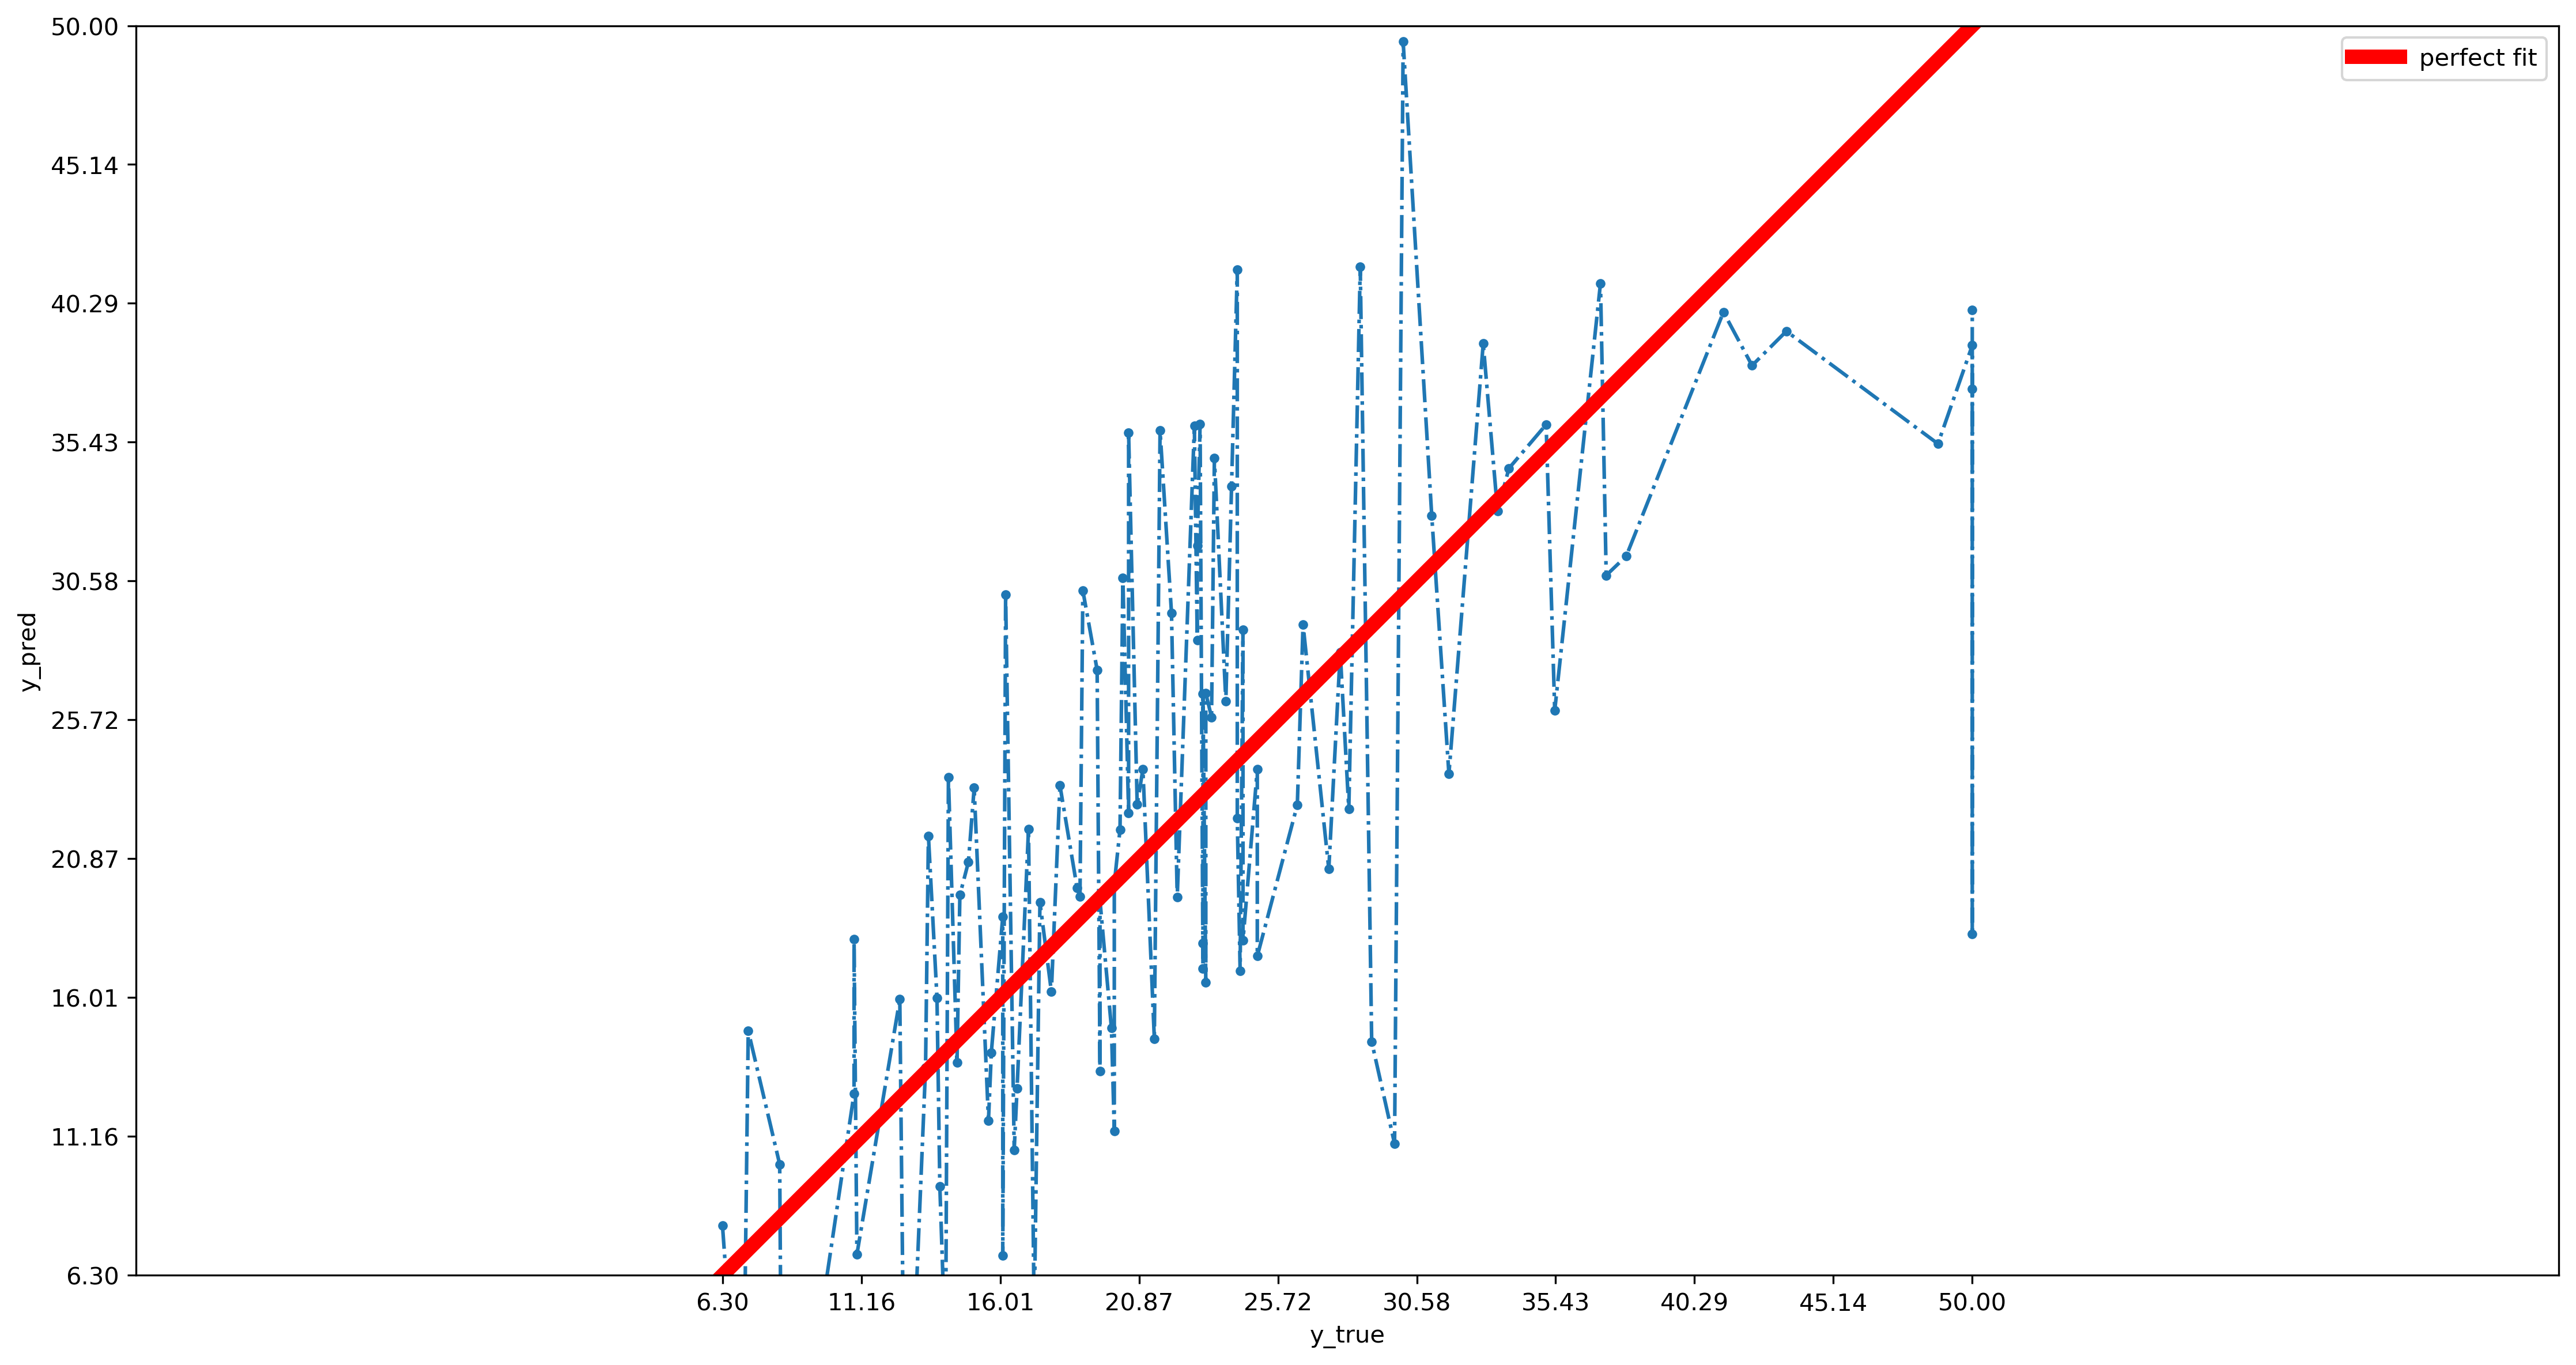

In [30]:
with torch.no_grad():
    predictions = torch.tensor([], device=device)
    true_ans = torch.tensor([], device=device)
    for val_batch, val_label in tqdm(dataset.next_val_batch()):
        preds = model_new(val_batch)
        predictions = torch.cat([predictions, preds], dim=0)
        true_ans = torch.cat([true_ans, val_label], dim=0)
    true_ans = true_ans.squeeze()
    predictions = predictions.squeeze()
    idx = torch.argsort(true_ans)
    true_ans = true_ans[idx].cpu().numpy()
    pred_ans = predictions[idx].cpu().numpy()
    
plt.figure(figsize=(15, 8), dpi=300)
plt.plot(true_ans, pred_ans, '-..')
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.axis('equal')
plt.xlim(true_ans.min(), true_ans.max())
plt.ylim(true_ans.min(), true_ans.max())
plt.xticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.yticks(ticks=np.linspace(true_ans.min(), true_ans.max(), 10))
plt.plot([true_ans.min(), true_ans.max()], [true_ans.min(), true_ans.max()], linewidth=6, c='r', label='perfect fit')
plt.legend()
plt.tight_layout()
plt.show();